<a href="https://colab.research.google.com/github/TCC0226/X_ray-detection/blob/main/ModelTraining4FaceScoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preprocessing

In [ ]:
#Interruption Preventing
%%javascript
function ClickConnect(){
    console.log("Working");
    document
        .querySelector("#top-toolbar > colab-connect-button")
        .shadowRoot
        .querySelector("#connect")
        .click()
}

setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#Installations
!pip install gspread 
!pip install oauth2client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Imports
import os
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import gspread
import time
from glob import glob
from statistics import mean
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from oauth2client.service_account import ServiceAccountCredentials as SAC
from matplotlib.ticker import PercentFormatter
from tensorflow.keras.callbacks import Callback

In [ ]:
#LINK TO GOOGLE DRIVE
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Get Google Sheets API Authorization
scopes = ["https://spreadsheets.google.com/feeds"]
credentials = SAC.from_json_keyfile_name("/content/drive/MyDrive/[Kaggle]ChestX-RayImages_Pneumonia/kaggle-pneumonia3_API_key.json", scopes) #金鑰位置
client = gspread.authorize(credentials)
sheet = client.open_by_key('(Replace with Google sheet id)') #Google Sheet 網址中最長的那段亂碼
sheet = sheet.worksheet('BUN') #分頁名稱

##Functions

In [ ]:
#Callback Function to Change monitor
class ChangeMonitor(Callback):
    def __init__(self, target, changee):
        self.target = target
        self.changee = changee

    def on_epoch_end(self, epoch, logs=None):
      if self.changee == 'recall' and not logs.get(self.changee):
        for i in range(1,10):
          if logs.get(self.changee + '_' + str(i)):
            self.target.monitor = self.changee + '_' + str(i)
            print('"{}" changes to "{}"!'.format(self.changee, self.changee+'_'+str(i)))
            break

In [ ]:
#Getting Confusion Matrix
def conf_matrix_and_prob(model, data_dir, test_gen, threshold):
    predictions =[]
    true_y = []
    ix = 0
    predictprob = np.zeros([test_gen.samples, len(test_gen.class_indices) if len(test_gen.class_indices)>2 else 1])

    for x,y in test_gen: 
      predictprob[ix,:] = model.predict(x)

      if len(test_gen.class_indices)>2:
        prediction = np.argmax(model.predict(x), axis=1)
        y = np.argmax(y, axis =1)
        
      else:
        prediction = [1 if model.predict(x) > threshold else 0]    
        
      predictions = np.concatenate((predictions, prediction))          
      true_y = np.concatenate((true_y, y))
      ix+=1
      
      if len(predictions) >= test_gen.samples:
          break

    matrix = confusion_matrix(true_y, predictions)

    return matrix, predictprob

In [ ]:
#Calculating N-classes Confusion Matrix
def calculate_metrics(confusion_matrix):
  if len(confusion_matrix)>2:
    classes = len(confusion_matrix)
    tps = []
    fps = []
    fns = []
    tns = []
    
    for i in range(classes):
      tps.append(confusion_matrix[i][i])
      fp = 0
      fn = 0
      tn = 0
      for j in range(classes):
        if j != i:
          fp += confusion_matrix[j][i]
          fn += confusion_matrix[i][j]
          for k in range(classes):
            if k != i:
              tn += confusion_matrix[j][k]
      fps.append(fp)
      fns.append(fn)
      tns.append(tn)

    accuracy = []
    recall = []
    precision = []
    f1_score = []
    
    for i in range(classes):
      tp = tps[i]
      fp = fps[i]
      fn = fns[i]
      tn = tns[i]
      acc = (tp + tn) / (tp + fn + fp + tn)
      rec = tp / (tp + fn)
      pre = tp / (tp + fp)
      f1 = 2 * pre * rec / (pre + rec)
      accuracy.append(acc)
      recall.append(rec)
      precision.append(pre)
      f1_score.append(f1)
  
  else:
    tp = confusion_matrix[1][1]
    fn = confusion_matrix[1][0] 
    fp = confusion_matrix[0][1] 
    tn = confusion_matrix[0][0] 

    accuracy = (tp + tn) / (tp + fn + fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
  
  return accuracy, recall, precision, f1_score

In [ ]:
#Ploting Confusion Matrix
def PlotConfusionMatrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
   
    #Normalization can be applied by setting `normalize = True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    acc, rec, pre, f1_s = calculate_metrics(cm)
    if len(classes) == 2:
      print(f'Accuracy: {acc:.3f}\nRecall: {rec:.3f}\nPrecision: {pre:.3f}\nF1 score: {f1_s:.3f}')
    else:
      print(f'Accuracy: {mean(acc):.3f}\nRecall: {mean(rec):.3f}\nPrecision: {mean(pre):.3f}\nF1 score: {mean(f1_s):.3f}')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#LINE Notify
def LineNotify(token,MSG):
    #HTTP 標頭參數與資料
    HEADERS = {"Authorization": "Bearer " + token} #token = API token of LINE Notify
    DATA = {'message': '\n' + MSG}  # 要發送的訊息
    #以 requests 發送 POST 請求
    requests.post("https://notify-api.line.me/api/notify", headers = HEADERS, data = DATA)

In [ ]:
#Converting sec to hr/min/sec
def time_convertion_string(s):
  string = ''
  if s//3600:
    string += f'{s//3600:2.0f} hr '
    s%=3600
  if s//60:
    string += f'{s//60:2.0f} min '
    s%=60
  string += f'{s:2.0f} sec'
  return string

time_convertion_string(12345.6789)

' 3 hr 25 min 46 sec'

##Model Setting

In [ ]:
#Variables Setting
model_characteristic = 'BUN' #【VERY IMPORTANT】BUN
classes = 3 if model_characteristic == 'BUN' else 2 
tok = '(Replace this string with Ur API token of LINE Notify)' #LINE Notify API token
m0del_name = 'Self-build CNN' #Name by yourself!
rotation_range = 5	#±degree
width_shift_range	= .05 #width_shift_range
height_shift_range = .05	#height_shift_range
validation_split = .2 #validation_split
vertical_flip = False #vertical_flip
horizontal_flip = True
rlr_factor = .3	
rlr_min_delta	= 1e-4 
es_min_delta = 1e-4
epoch = 30
batch_size = 32
input_shape1 = 128 #target_size[0]
rlr_monitor = 'val_loss' 
es_monitor = 'loss'
mckp_monitor = 'recall'
zoom_range = .2 #zoom_range
class_weight = {0 : 1, 1 : 1} 
tester = '莊孝穎'
PS = ''
threshold = .5
zca_whitening = False
preprocessing_function = tf.keras.applications.densenet.preprocess_input

In [ ]:
#Generator Setting
generator = ImageDataGenerator(
                rescale = 1./255,
                validation_split = validation_split, # fraction of validation
                zca_whitening = zca_whitening,  # apply ZCA whitening
                rotation_range = rotation_range,  # randomly rotate images in the range ±degree (degrees, 0 to 180)
                width_shift_range = width_shift_range,  # randomly shift images horizontally (fraction of total width)
                height_shift_range = height_shift_range,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = horizontal_flip,  # randomly flip images horizontally
                vertical_flip = vertical_flip,  # randomly flip images vertically
                zoom_range = zoom_range,
                preprocessing_function = preprocessing_function
                )
testgenerator = ImageDataGenerator(rescale = 1./255, preprocessing_function = preprocessing_function)

In [ ]:
#Directions Setting
train_dir = '/content/drive/MyDrive/chest_xray/Cropped_asia_faces/train/F/'
tst_dir  = '/content/drive/MyDrive/chest_xray/Cropped_asia_faces/test/F/'

In [ ]:
#Gens Setting
target_size = [input_shape1, input_shape1]
train_gen = generator.flow_from_directory(train_dir, 
                      class_mode = 'binary' if classes == 2 else 'categorical',
                      target_size = target_size, 
                      batch_size = batch_size, 
                      shuffle = True,
                      seed = 101,
                      subset = 'training')

validation_data = generator.flow_from_directory(train_dir, 
                          class_mode = 'binary' if classes == 2 else 'categorical',
                          target_size = target_size, 
                          batch_size = batch_size, 
                          shuffle = True,
                          seed = 101,
                          subset = 'validation')

tst_gen  = testgenerator.flow_from_directory(tst_dir,
                        target_size = target_size,                                          
                        batch_size = 1,
                        shuffle = False,
                        class_mode = 'binary' if classes == 2 else 'categorical'
                        )

for dir in glob(train_dir + '/*'):
  print('There\'re {} pics in {}'.format(len(glob(dir + '/*')), dir))

Found 1602 images belonging to 3 classes.
Found 399 images belonging to 3 classes.
Found 209 images belonging to 3 classes.
There're 613 pics in /content/drive/MyDrive/chest_xray/Cropped_asia_faces/train/F/beautifulF
There're 702 pics in /content/drive/MyDrive/chest_xray/Cropped_asia_faces/train/F/normalF
There're 686 pics in /content/drive/MyDrive/chest_xray/Cropped_asia_faces/train/F/uglyF


(128, 128, 3)

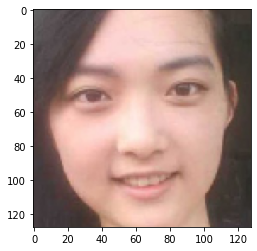

In [ ]:
#Randomly Showing img.
all_img = glob(tst_dir + '/*/*')
img_path = random.choice(all_img)
img = tf.keras.preprocessing.image.load_img(img_path, target_size = target_size)  # 讀取影像將影像resize到網路輸入大小
img = tf.keras.preprocessing.image.img_to_array(img) #將影像轉為array
plt.imshow(img/255.) 
img.shape 

In [ ]:
#Class & No.
train_gen.class_indices

{'beautifulF': 0, 'normalF': 1, 'uglyF': 2}

In [ ]:
# #Self-build CNN
# model = Sequential()
# model.add(Conv2D(32,(3,3),input_shape = img.shape))
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(64,(6,6)))
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(128,(9,9)))
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(1 if classes == 2 else classes))
# model.add(Activation("softmax"))

# model.summary()

In [ ]:
base_model = tf.keras.applications.DenseNet201(
                          include_top=False, 
                          weights='imagenet', 
                          pooling='avg', 
                          input_shape=img.shape
                        )
model = tf.keras.Sequential([
                base_model,
                layers.Dense(128, activation='relu'), 
                layers.Dense(classes, activation='softmax')
                ])

74836368/74836368 [==============================] - 5s 0us/step


In [ ]:
#Model Compiling
model.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["categorical_crossentropy", Recall(), Precision()])

In [ ]:
#Callbacks Setting
model_dir = '/content/drive/MyDrive/[Kaggle]ChestX-RayImages_Pneumonia'
rlr = keras.callbacks.ReduceLROnPlateau(monitor = rlr_monitor, factor = rlr_factor, patience=2, verbose=1, min_delta = rlr_min_delta)
early_stopping = tf.keras.callbacks.EarlyStopping(
                          monitor = es_monitor,
                          min_delta = es_min_delta,
                          patience = 5,
                          )
model_mckp = keras.callbacks.ModelCheckpoint(
                        os.path.join(model_dir, 'best_model.h5'), 
                        monitor = mckp_monitor, 
                        save_best_only = True, 
                        mode = 'max',
                       )
callbacks = [rlr, model_mckp, ChangeMonitor(model_mckp, mckp_monitor)]

##Model Training & Result

In [ ]:
itime = time.time()

try:
  history  = model.fit(
            train_gen, 
            steps_per_epoch = train_gen.samples//batch_size, 
            epochs = epoch,
            validation_data = validation_data, 
            validation_steps = validation_data.samples//batch_size,
            #class_weight = class_weight,
            callbacks = callbacks
            )
except Exception as e:
  raise
  print(e)

train_time = (time.time() - itime)/60.
print(f'train time : {time_convertion_string(train_time*60)}')

Epoch 1/30
50/50 [==============================] - 1009s 20s/step - loss: 0.9695 - categorical_crossentropy: 0.9695 - recall: 0.3955 - precision: 0.5580 - val_loss: 9.9683 - val_categorical_crossentropy: 9.9683 - val_recall: 0.3542 - val_precision: 0.3542 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 21s 428ms/step - loss: 0.7538 - categorical_crossentropy: 0.7538 - recall: 0.5643 - precision: 0.6597 - val_loss: 1.2499 - val_categorical_crossentropy: 1.2499 - val_recall: 0.0365 - val_precision: 0.2545 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 22s 434ms/step - loss: 0.7195 - categorical_crossentropy: 0.7195 - recall: 0.6153 - precision: 0.6861 - val_loss: 1.7454 - val_categorical_crossentropy: 1.7454 - val_recall: 0.3073 - val_precision: 0.3073 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.6945 - categorical_crossentropy: 0.6945 - recall: 0.6395 - precision: 0.6967
Epoch 4: ReduceLROnPlateau reducing learnin

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_crossentropy', 'recall', 'precision', 'val_loss', 'val_categorical_crossentropy', 'val_recall', 'val_precision', 'lr'])

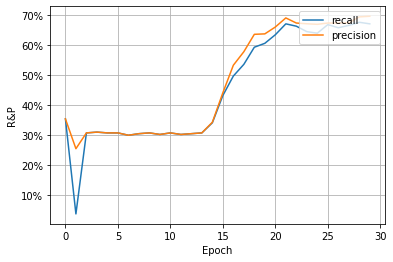

In [ ]:
#Ploting Loss
y_axis = plt.gca().yaxis
y_axis.set_major_formatter(PercentFormatter(1))
for key in history.history.keys():
  if 'recall' in key:
    recall_key = key
  elif 'precision' in key:
    precision_key = key
plt.plot(history.history[recall_key], label = 'recall')
plt.plot(history.history[precision_key], label = 'precision')
plt.ylabel('R&P')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

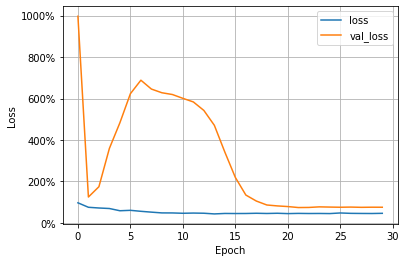

In [ ]:
#Ploting Loss
y_axis = plt.gca().yaxis
y_axis.set_major_formatter(PercentFormatter(1))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

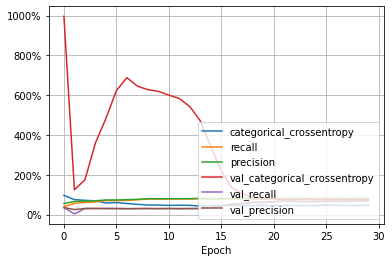

In [ ]:
#Ploting Important Results
y_axis = plt.gca().yaxis
y_axis.set_major_formatter(PercentFormatter(1))
for key in history.history.keys():
  if key not in ['loss','lr','val_loss']:
    plt.plot(history.history[key], label = key)
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

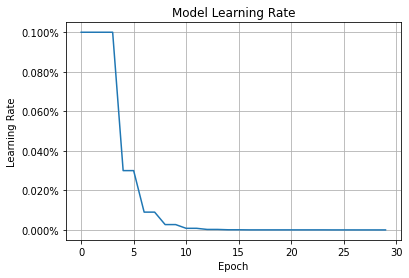

In [ ]:
#Ploting Learning Rate
y_axis = plt.gca().yaxis
y_axis.set_major_formatter(PercentFormatter(1))
plt.plot(history.history['lr'])
plt.title('Model Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

In [ ]:
#Evaluating
test_result = model.evaluate(tst_gen)

209/209 [==============================] - 163s 779ms/step - loss: 0.7270 - categorical_crossentropy: 0.7270 - recall: 0.6603 - precision: 0.6765


##Post-processing

In [ ]:
#Renaming Model
locT = time.localtime()
model_name = 'FaceScore%d%s_%d%d%d%d%d_acc%d_rec%d_prec%d.h5'%(classes,
                                model_characteristic,
                                locT.tm_year - 2000,
                                locT.tm_mon,
                                locT.tm_mday,
                                locT.tm_hour + 8,
                                locT.tm_min,
                                test_result[1]*100, 
                                test_result[2]*100, 
                                test_result[3]*100)

if os.path.exists(model_dir + '/best_model.h5'):
  os.rename(model_dir + '/best_model.h5', os.path.join(model_dir, model_name))
  print('model name = ',model_name)
else:
  print('Best Model not found!')

model name =  FaceScore3BUN_231121742_acc72_rec66_prec67.h5


In [ ]:
#Model Checking
model = tf.keras.models.load_model(os.path.join(model_dir, model_name))
conf_matrix, prob = conf_matrix_and_prob(model, tst_dir, tst_gen, threshold)
conf_matrix[:,:]

1/1 [==============================] - 0s 34ms/step


array([[60,  7,  0],
       [19, 35, 18],
       [ 2, 20, 48]])

Confusion matrix, without normalization
Accuracy: 0.789
Recall: 0.689
Precision: 0.678
F1 score: 0.680


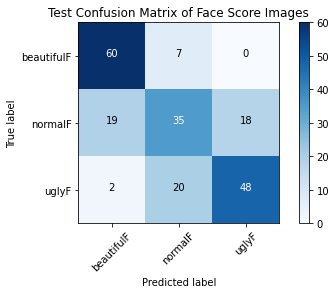

In [ ]:
#Ploting Confusion Matrix
labels = [i[0] for i in list(tst_gen.class_indices.items())]
PlotConfusionMatrix(conf_matrix, labels, title = "Test Confusion Matrix of Face Score Images")

In [ ]:
#Result Reporting    
LineNotify(tok, f'Model trained. (Best Model = {model_name})\nby {tester}.')

In [ ]:
#Key-in Data Setting
data = {'recall' : test_result[2]*100, 'precision' : test_result[3]*100, 'accuracy' : test_result[1]*100,
      'model name' : m0del_name, 'rotation' : rotation_range, 'w_shift' : width_shift_range, 'h_shift' : height_shift_range,
      'vertical' : 1 if vertical_flip else 0, 'horizon' : 1 if horizontal_flip else 0, 'val_split' : validation_split,
      'earlyStop' : 1 if early_stopping in callbacks else 0, 'rlr': 1 if rlr in callbacks else 0, 
      'rlr_factor' : rlr_factor, 'input_shape[1]' : input_shape1, 'es_min_delta' : es_min_delta,
      'epoch' : epoch, 'batch size' : batch_size, 'Tester' : tester, 'rlr_min_delta' : rlr_min_delta,
      'zoom' : zoom_range, 'mckp_monitor' : mckp_monitor,	'rlr_monitor' : rlr_monitor,	
      'earlyStop_monitor' : es_monitor, 'Date' : f'{locT.tm_year}.{locT.tm_mon}.{locT.tm_mday}',
      'weight' : str(class_weight), '.h5'  : model_name, 'PS' : PS, 'Train Time (min)' : train_time
    }

In [ ]:
#Data Filling
whole_sheet = sheet.get_all_values()
for key, value in data.items():
  keyin_col = sheet.find(key).col
  if not keyin_col:
    print('Can\'t find ',key)
  else:
    sheet.update_cell(len(whole_sheet)+1, keyin_col, value)